In [1]:
# execute to import notebook styling for tables and width etc.
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
HTML(response.read().decode("utf-8"));

import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports
%matplotlib notebook
from scipy.optimize import minimize
import babel.numbers as numbers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import array
import random
import json
from deap import algorithms, base, creator, tools
import numpy as np
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings('ignore')

# Simulated Annealing for TSP with 48 cities

Adapt our "homemade" simulated annealing code from Section 2.1 in the lesson to solve the 48 capitals TSP problem from last week.  The json file `Caps48.json` in the data folder has both the distance matrix and the coordinates of the cities for plotting.  Note the distance of typical random tour is something like 80,000,000 meters and we're looking for something under 18,000,000 meters.  Your initial temperature has to be large enough to allow large moves on this scale and you'll have to increase `max_moves_no_improve` as well.  You should plot the progress of the search, like in the lesson, and you should plot the final result on the map of the United States as we did last week (that code is given in a cell below). Included a value for the random seed so that your results are reproducible.  Report a search that gives total distance < 18,000,000 meters.  A tour that achieves the optimum distance is shown in the json file.  

Put your code to find the solution in the cell below.  Your output should include a convergence plot like in the lesson (best distance versus iteration and current distance versus iteration).

<font color = "blue"> *** 4 points -  answer in cell below *** (don't delete this cell) </font>

In [ ]:
# load data (this may have to be adapted for different problems)
with open("data/Caps48.json", "r") as caps_data:
    caps = json.load(caps_data)
distance_matrix = caps["DistanceMatrix"]
individual_size = caps["TourSize"]


# define objective function
def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance


def sub_tour_reversal(tour):
    # reverse a random tour segment
    i, j = np.sort(np.random.choice(individual_size, 2, replace=False))
    swapped = np.concatenate((tour[0:i], tour[j:-individual_size + i - 1:-1],
                              tour[j + 1:individual_size]))
    return [int(swapped[i]) for i in range(individual_size)]



def random_reversals(max_moves_no_improve):
    # Random Number Seed
    # if you want reproducible results, then uncomment the following line
    # and play with the seed value until you get a result you like. If you run 
    # it again with the same value, then you'll get the same result.
    np.random.seed(987)

    # initialize with a random tour
    current_tour = np.random.permutation(np.arange(individual_size)).tolist()
    current_dist = tour_distance(current_tour, distance_matrix)
    best_tour = current_tour
    best_dist = current_dist
    temp = 80  # choose initial temperature around the beginning tour distance
    alpha = 0.99
    iteration = 1
    print('Starting Distance {:d} and Starting Temp {:d}\n'.format(
        current_dist, temp))
    print('New | Current | Delta | Best | Accept |  Prob  | Temp')

    # these two variables just save info for plotting but aren't 
    # essential for the algorithm
    trajectory = [[iteration,current_dist]]
    trajectory_best = [[iteration,best_dist]]

    num_moves_no_improve = 0
    iteration = 0
    
    while (num_moves_no_improve < max_moves_no_improve):

        num_moves_no_improve += 1
        new_tour = sub_tour_reversal(current_tour)
        new_dist = tour_distance(new_tour, distance_matrix)
        delta = current_dist - new_dist
        prob = np.exp(min(delta, 0) / temp)
        accept = new_dist < current_dist or np.random.uniform() < prob

        # probably remove the print statement in your own code
        print('{:3d} |   {:3d}   |  {:4d} |  {:3d} |   {:>3}  | {:0.4f} | {:2.2f}'.format(
            new_dist, current_dist, delta, best_dist, "yes" if accept else "no", prob,
            temp))

        if accept:
            current_tour = new_tour
            current_dist = new_dist
            if current_dist < best_dist:
                best_tour = current_tour
                best_dist = current_dist
                num_moves_no_improve = 0
        temp *= alpha
        iteration += 1
        trajectory.append([iteration,current_dist])
        trajectory_best.append([iteration,best_dist])
        
    return best_tour, best_dist, iteration

best_tour, best_dist, iterations = random_reversals(1000)

Plot the tour on the map of the U.S.  Code to do this is below.

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

In [ ]:
# load the data and define move and objective functions
thismap = Basemap(llcrnrlon=-119,
              llcrnrlat=22,
              urcrnrlon=-64,
              urcrnrlat=49,
              projection='lcc',
              lat_1=32,
              lat_2=45,
              lon_0=-95)

# read 48 capitals lat and lon
with open('./data/Caps48.json', 'r') as json_file:
    capitals = json.load(json_file)

xy = np.array(capitals['Coordinates'])

def plot_tour(best_tour, xy, best_dist):
    fig = plt.figure()
    fig.set_size_inches(6, 4)

    # load the shape file with "states"
    thismap.readshapefile('./data/st99_d00', name='states', drawbounds=True)

    loop_tour = np.append(best_tour, best_tour[0])
    thismap.plot(xy[:, 0], xy[:, 1], c='r', marker='o', markersize=4, linestyle='')
    lines, = thismap.plot(xy[loop_tour, 0],
                      xy[loop_tour, 1],
                      c='b',
                      linewidth=1,
                      linestyle='-')
    plt.title('Best Distance {:d} km'.format(int(best_dist)))
        
plot_tour(best_tour, xy, best_dist)
print('The minimum distance found is {:d} after {:d} iterations'.format(
    int(best_dist), iterations))

Based on the plot of the tour do you think you have found a nearly optimal tour.  Explain why or why not.

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

Based on the plot, it does look like I'm pretty close to the optimal distance because the contour of the route seems efficient and minimizes the area of the shape.

# Knapsack with simanneal package

The knapsack problem is a classical combinatorial optimization problem that will be good for practicing with the ideas of discrete local search and multistart.  Given a set of items, each with a weight and a value, determine which items to include in a collection so that the total weight is less than or equal to a given limit and the total value is as large as possible.  In the 0-1 version of the knapsack problem, the decision variables are binary (or boolean) and represent whether or not to include each item in the collection.  We'll start with 20 items and you need to determine the collection of items that maximizes the value and keeps the total weight up to 50 (that is $\leq 50$).

In [ ]:
# generate random weights and values for a knapsack problem
import numpy as np
num_items = 20
np.random.seed(seed=123)
values = np.random.randint(low=5, high=50, size=num_items)
weights = np.random.randint(low=1, high=10, size=num_items)
max_weight = 50
np.random.seed() # use system clock to reset the seed so future random numbers will appear random

Use the `simanneal` package to apply simulated annealing to finding a good solution to this knapsack problem. Show your solution below.  We suggest using lists of booleans to represent the items included in the knapsack as we did last week.

<font color = "blue"> *** 9 points -  answer in cell below *** (don't delete this cell) </font>

In [ ]:
from simanneal import Annealer

class knapsack_problem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, values, weights):
        self.weights = weights
        self.values = values
        super(knapsack_problem, self).__init__(state)  # important!

    def move(self):
        """Reverse random segment"""
        knapsack = self.state
        n = len(knapsack)
        bit_to_flip = np.random.randint(n)
        knapsack[bit_to_flip] = ~knapsack[bit_to_flip]
        weight = sum(self.weights[knapsack])
        self.state = knapsack

        if weight <= 50:            
            return self.energy()
        else:
            return self.move()
    
    def energy(self):
        """Compute tour distance"""
        knapsack = self.state
        knapsack_value = -sum(self.values[knapsack])
        return knapsack_value

knapsack = np.zeros(20, dtype = bool)

ksp = knapsack_problem(knapsack, values, weights)
ksp.set_schedule(ksp.auto(minutes=.1))
ksp.copy_strategy = "slice" #"method"
knapsack, value = ksp.anneal()

print(f"knapsack: {knapsack}\nvalue: {abs(value)}")

Do you think you've found the knapsack with highest possible value (the global max)?  Why or why not?

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

I think it's possible that I found the global max because the value does not increase any further when I adjust the algorithm run-time/iterations (minutes). If it's not the global max, then it's close to it.

# 48 Capital TSP with Genetic Algorithm

Use the DEAP genetic algorithm described in the lesson to approximate a solution to the 48 state capital TSP introduced last week.  The distance matrix (in meters) and city coordinates are in `data/Caps48.json`.  Experiment with the algorithm parameters until you can find a tour of length $\leq$ 19,000,000 meters (19,000 kilometers).  Uncomment the random.seed() line and possibly try different seed values so that, if all the other parameters are the same, running the algorithm again will produce the same results.

Put your code in the cell below. Make sure it prints out both the best tour and the tour distance.  Feel free to divide distances by 1000 to display results in kilometers.

<font color = "blue"> *** 4 points -  answer in cell below *** (don't delete this cell) </font>

In [28]:
def customGA(pop_size, cx_prob, mut_prob, max_gen, max_no_improve):
    random.seed(333)
    pop = toolbox.population(n=pop_size)
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    best_val = hof[0].fitness.values
    num_no_improve = 0
    generation = 0

    while num_no_improve < max_no_improve and generation < max_gen:

        # Select the next generation individuals
        selected = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, selected))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        num_evals = 0
        for ind, fit in zip(invalid_ind, fitnesses):
            num_evals += 1
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # track the best value and reset counter if there is a change
        hof.update(pop)
        curr_best_val = hof[0].fitness.values[0]
        num_no_improve += 1
        if curr_best_val != best_val:
            best_val = curr_best_val
            num_no_improve = 0

        # record stats
        record = stats.compile(pop)
        logbook.record(gen=generation, evals=num_evals, **record)

        # increment generation
        generation += 1

    best_x = list(hof[0])

    return best_val, best_x, logbook

# imports
import array
import random
import json
from deap import algorithms, base, creator, tools
import numpy as np

# load data (this may have to be adapted for different problems)
with open("data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# define objective function
def tour_distance(individual, dist_mat):
    # an individual is a tour 
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance    

def tour_distance_tuple(individual, dist_mat):
    return (tour_distance(individual, dist_mat),)

# create a minimization problem
creator.create("FitnessTSP", base.Fitness, weights=(-1.0, ))
# tells us what kind of individuals we'll have - arrays of integers

creator.create("Individual",
               list,
               typecode='i',
               fitness=creator.FitnessTSP)

# configure toolbox
toolbox = base.Toolbox()
# define how we create an individual and a poopulation
def create_individual(individual_size):
    np.random.seed(333)
    return random.sample(range(individual_size),individual_size) # choose a random permutation of 0 .... individual_size-1

toolbox.register("indices",create_individual,individual_size)

toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# set the fitness function
# notice we are registering the distance matrix from above as an extra argument
toolbox.register("evaluate", tour_distance_tuple, dist_mat=distance_matrix)

# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", tools.cxPartialyMatched)
# Mutation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 500
crossover_prob = 0.6
mutation_prob = 0.3
max_gen = 1000
max_no_improve = 100

# get solution
best_dist, best_tour, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

 Make a plot of the best tour.

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

<IPython.core.display.Javascript object>


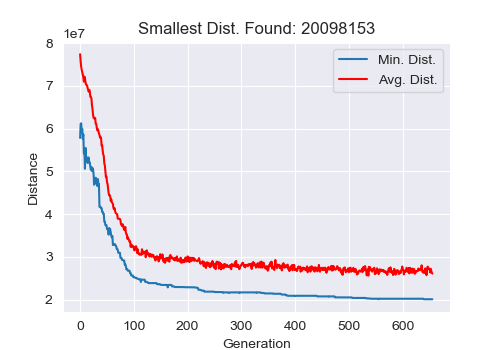

In [29]:
# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_min, = plt.plot(log.select('gen'), log.select('min'), label='Min. Dist.')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg. Dist.')
#line_max, = plt.plot(log.select('gen'),log.select('max'),color='green',label='Max. Val.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_min, line_avg])
plt.title('Smallest Dist. Found: {:d}'.format(int(best_dist)));

Based on the plot of the tour do you think you have found a nearly optimal tour.  Explain why or why not.

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

No. I think this algorithm brings us into spatial proximity of the optimal tour, but not nearly close enough.

# 48 Capital TSP with Genetic Algorithm and Local Search

Genetic algorithms are great for exploring a large solution space, but not so good at refining the details when close to an optimal solution.  For this reason genetic algorithms are often combined with local search.  The idea is that at each generation some or all of the individuals in the population are replaced by the result of a local search.  We'll explore this by using the 2-opt local search for TSP to refine the three worst tours in each generation.  Create a new customGA() algorithm called customGA_TSP_LS() and include this code at the beginning of the while loop:

```
# replace 3 worst individuals with local searches
pop.sort(key=lambda x:x.fitness.values,reverse=True)
num_loc_search = 3
for i in range(num_loc_search):
    best_tour, best_dist, iterations = two_opt(list(pop[i]),distance_matrix)
    pop[i] = creator.Individual(best_tour)
    pop[i].fitness.values = (best_dist,)
```
This finds the three worst tours and does a 2-opt local search on each and then replaces the results in the population.

You'll also need this version of the 2-opt search that uses the distance matrix:

In [33]:
def sub_tour_reversal_ij(tour,i,j):
    n = len(tour)
    return (np.concatenate((tour[0:i], tour[j:-n + i - 1:-1], tour[j + 1:n])).astype(int))

def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return (distance,) 

def two_opt(start_tour,dist_mat):
    num_cities = len(start_tour)
    current_dist = tour_distance(start_tour, dist_mat)[0]
    best_tour = start_tour
    best_dist = current_dist

    improvement = True
    iterations = 0
    while improvement:
        improvement = False
        for i in range(num_cities - 1):
            for j in range(i + 1, num_cities):
                iterations += 1
                new_tour = sub_tour_reversal_ij(best_tour, i, j)
                new_dist = tour_distance(new_tour, dist_mat)[0]
                if new_dist < best_dist:
                    best_tour = new_tour
                    best_dist = new_dist
                    improvement = True
    return best_tour, best_dist, iterations

def tour_distance_tuple(individual, dist_mat):
    return tour_distance(individual, dist_mat)

Put your customGA_TSP_LS function in the next cell. You can run this version of the algorithm with a much smaller population and for far fewer iterations.  Find a tour of length $\leq$ 17,500 km. Use a random number seed for reproducibility.  Put your code in the next cell and print out the best distance and tour.


<font color = "blue"> *** 6 points -  answer in cell below *** (don't delete this cell) </font>

In [38]:
def customGA_TSP_LS(pop_size, cx_prob, mut_prob, max_gen, max_no_improve):

    pop = toolbox.population(n=pop_size)
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    best_val = hof[0].fitness.values
    num_no_improve = 0
    generation = 0

    while num_no_improve < max_no_improve and generation < max_gen:
        # replace 3 worst individuals with local searches
        pop.sort(key=lambda x:x.fitness.values,reverse=True)
        num_loc_search = 3
        for i in range(num_loc_search):
            best_tour, best_dist, iterations = two_opt(list(pop[i]),distance_matrix)
            pop[i] = creator.Individual(best_tour)
            pop[i].fitness.values = (best_dist,)        

        # Select the next generation individuals
        selected = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, selected))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            random.seed(333)
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        num_evals = 0
        for ind, fit in zip(invalid_ind, fitnesses):
            num_evals += 1
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # track the best value and reset counter if there is a change
        hof.update(pop)
        curr_best_val = hof[0].fitness.values[0]
        num_no_improve += 1
        if curr_best_val != best_val:
            best_val = curr_best_val
            num_no_improve = 0

        # record stats
        record = stats.compile(pop)
        logbook.record(gen=generation, evals=num_evals, **record)

        # increment generation
        generation += 1

    best_x = list(hof[0])

    return best_val, best_x, logbook

In [53]:
# imports
import array
import random
import json
from deap import algorithms, base, creator, tools
import numpy as np

# load data (this may have to be adapted for different problems)
with open("data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# create a minimization problem
creator.create("FitnessTSP", base.Fitness, weights=(-1.0, ))
# tells us what kind of individuals we'll have - arrays of integers

creator.create("Individual",
               list,
               typecode='i',
               fitness=creator.FitnessTSP)

# configure toolbox
toolbox = base.Toolbox()
# define how we create an individual and a poopulation
def create_individual(individual_size):
    random.seed(333)
    return random.sample(range(individual_size),individual_size) # choose a random permutation of 0 .... individual_size-1
toolbox.register("indices",create_individual,individual_size)

toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# set the fitness function
# notice we are registering the distance matrix from above as an extra argument
toolbox.register("evaluate", tour_distance_tuple, dist_mat=distance_matrix)

# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", tools.cxPartialyMatched)
# Mutation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 60
crossover_prob = 0.8
mutation_prob = 0.4
max_gen = 300
max_no_improve = 50

# get solution
best_dist, best_tour, log = customGA_TSP_LS(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

Plot the best tour below. 

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

<IPython.core.display.Javascript object>


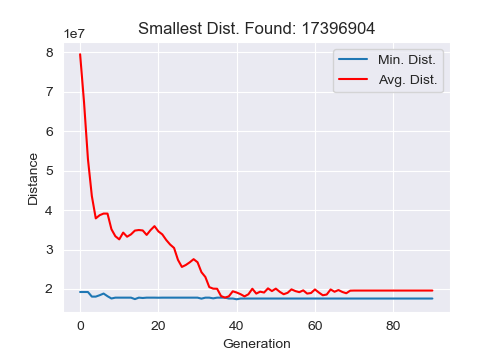

In [54]:
# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_min, = plt.plot(log.select('gen'), log.select('min'), label='Min. Dist.')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg. Dist.')
#line_max, = plt.plot(log.select('gen'),log.select('max'),color='green',label='Max. Val.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_min, line_avg])
plt.title('Smallest Dist. Found: {:d}'.format(int(best_dist)));

Is this a good tour?  Explain.

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

Yes, I think this tour is probably < 1% away from the global optimal. I'm not 100% certain because the answer is iteratively calculated instead of mathematically derived, but it looks much better than GA without local search.

# Knapsack problem with GA

Use the DEAP framework to build a genetic algorithm to solve the knapsack problem (same as in problem 2).  

The individuals should be lists of booleans:
```
def create_individual(n):
    return random.choices([True, False], k=n)
```

Use tournament selection and one point crossover.  For mutation flip booleans at random with this:
```
toolbox.register("mutate", tools.mutFlipBit, indpb=.1)
```

Here is a non-tuple version of a fitness function to get you started.  Notice that it includes a penalty term that penalizes if the knapsack is over the maximum weight.

```
def knapsack_value(x, values, weights, max_tot_weight):
    # x is a vector of booleans of which items to include
    tot_value = sum(values[x])
    penalty = sum(values)*min( max_tot_weight - sum(weights[x]), 0) 
    return tot_value+penalty
```
    
Put your code in the cell below.  Use random.seed() to make reproducible results.

<font color = "blue"> *** 9 points -  answer in cell below *** (don't delete this cell) </font>

Do you think you've found the knapsack with highest possible value (the global max)?  Why or why not?

<font color = "blue"> *** 1 points -  answer in cell below *** (don't delete this cell) </font>

# 30 dimensional Rastrigin Function

30 dimensions means that each individual or potential solution is a list of 30 real numbers each between -5.12 and 5.12.  Use either `simanneal` or `DEAP` (or both) to find the global optimum value (it's zero and happens when $x_1 = x_2 = \ldots = x_{30}$). Use random number seeds to make your search reproducible - `random.seed()` and/or `numpy.random.seed`, you may even need to set both since DEAP and simanneal both use `random` while we've been using `np.random` for generating moves and picking starting points for continuous optimization.   You should add a global variable to count the number of times you call the Rastrigin function and report that number as well.

<font color = "blue"> *** 8 points -  answer in cell below *** (don't delete this cell) </font>

In [ ]:
def rastrigin(x):
    x = np.array(x) # force a numpy arrray here so that the math below works
    # pass a single vector of length n (=dim) to evaluate Rastrigin
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

# add your code here:

Scipy.optimize also includes two optimization routines for continuous optimization that are similar to simulated annealing.  Both dual_annealing and basinhopping combine local search with an annealing-like process.  Run the code in the next two cells and then write about your results at the bottom.  You can try changing maxiter in dual_annealing and niter in basinhopping if you don't find the global minimum right away. 

In [ ]:
# run this cell for dual_annealing on 30D Rastrigin (mostly thanks to Deanna S.)
from scipy.optimize import dual_annealing
import numpy as np

dim = 30
bounds = [(-5.12, 5.12) for i in range(dim)]

#this tells scipy minimize which method to use
minimizer_kwargs = {"method": "TNC"}

#define a function so we can see what's happening
results = []
acceptedVal = []
def print_fun(x, f, accepted):
        results.append(f)
        acceptedVal.append(int(accepted))

# call dual_annealing
result = dual_annealing(rastrigin, bounds, maxiter = 200)

print(
    'The lowest value of {:0.4f} took {:d} iterations and {:d} function evaluations.'
    .format(result.fun, result.nit, result.nfev))
print('The location of this lowest value is:')
print(result.x)

iterations = [i for i in range(len(log))]
import matplotlib.pyplot as plt
# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_min, = plt.plot(iterations, log, label='Min. Dist.')

plt.xlabel('Iteration')
plt.ylabel('Accepted function value')
plt.legend(handles=[line_min])
plt.title('Smallest value Found: {:4f}'.format(min(log)));

In [ ]:
# run this cell for basinhopping on 30D Rastrigin (mostly thanks to Deanna S.)
%matplotlib notebook
from scipy.optimize import basinhopping
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

#set up the variables and initial vector
low = -5.12
high = 5.12
num_dim = 30
x0 = np.random.uniform(low=-5.12,high=5.12,size=num_dim)

#set up our basic rastrigin function
def rastrigin(x):
    x = np.array(x)
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

#We need to use bounds, so set up a custom MyBounds object
class MyBounds(object):
    def __init__(self, xmax=[high] * num_dim, xmin=[low] * num_dim ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

#create an instance of the bounds object
mybounds = MyBounds()

#this tells scipy minimize which method to use
minimizer_kwargs = {"method": "TNC"}

#define a function so we can see what's happening
log = []
acceptedVal = []
def print_fun(x, f, accepted):
        log.append(f)
        acceptedVal.append(int(accepted))

#run it
result = basinhopping(rastrigin, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=200, accept_test=mybounds,
                   callback=print_fun)

print(
    'The lowest value of {:0.4f} took {:d} iterations and {:d} function evaluations.'
    .format(result.fun, result.nit, result.nfev))
print('The location of this lowest value is:')
print(result.x)

iterations = [i for i in range(len(log))]
import matplotlib.pyplot as plt
# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_min, = plt.plot(iterations, log, label='Min. Dist.')

plt.xlabel('Iteration')
plt.ylabel('Accepted function value')
plt.legend(handles=[line_min])
plt.title('Smallest value Found: {:4f}'.format(min(log)));

How does your optimization result (from DEAP and/or simanneal) compare to the results found by dual_annealing and basinhopping in terms of accuracy and efficiency?  Give a brief summary and comparision of the results.

<font color = "blue"> *** 2 points -  answer in cell below *** (don't delete this cell) </font>